# Pendulum Experiment

Estimate the Earth's gravitational acceleration through a pendulum experiment

## Author(s), contact(s), dates
* Silja Svendsen (wng830@alumni.ku.dk)

* 29/11/2023 (latest update)

In [1]:
# import needed packages
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Module to see files and folders in directories
from scipy import stats

from IPython.core.display import Latex

def lprint(*args,**kwargs):
    """Pretty print arguments as LaTeX using IPython display system 
    
    Parameters
    ----------
    args : tuple 
        What to print (in LaTeX math mode)
    kwargs : dict 
        optional keywords to pass to `display` 
    """
    display(Latex('$$'+' '.join(args)+'$$'),**kwargs)

In [2]:
sys.path.append('/Users/siljaxianpallisgaardsvendsen/Documents/KU_K/8_AppStat/AppStat2023/External_Functions/')
from ExternalFunctionsNew import UnbinnedLH, BinnedLH, Chi2Regression
from ExternalFunctionsNew import nice_string_output, add_text_to_ax   # Useful functions to print fit results on figure

In [3]:
# plotting settings
sns.set()
sns.set_context("paper", font_scale = 1.4)
sns.set_style("ticks")

In [12]:
save_plots = False
verbose = False

In [21]:
# load T data
pendulum = []
for filepath in glob.glob('/Users/siljaxianpallisgaardsvendsen/Documents/KU_K/8_AppStat/AppStatProject1/timer_*pendulum.txt'):
    data = np.loadtxt(filepath)
    pendulum.append(data[0:27]) #ensure all data set have the same length.

if (verbose):
    print(pendulum)

In [22]:
# Estimated T and their uncertainties from different measurement processes
# T_final values and their uncertainties are appended from second linear fit
T_final = []
sigmaT_final = []

## First linear fit: get an estimate of the period (the slope)

In [23]:
experiment_number = 0 # change this one for each measurement process obtained

# the following lines are for readability only
oscillation_number = 0
time_point = 1

In [29]:
tdiff = np.diff(pendulum[experiment_number][:,time_point])
sigmat = np.sqrt(np.mean((tdiff-np.mean(tdiff))**2)) #RootMeanSquaredDistance
print('A good initial guess on the time error', sigmat)

tdiff

A good initial guess on the time error 0.09103215083258744


array([2.7166, 2.5602, 2.7721, 2.7733, 2.6426, 2.6542, 2.8021, 2.6665,
       2.6395, 2.7416, 2.6999, 2.708 , 2.6502, 2.7685, 2.7501, 2.563 ,
       2.8619, 2.6891, 2.4798, 2.8504, 2.8085, 2.6604, 2.7022, 2.5809,
       2.7958, 2.7132])

In [30]:
Npoints = np.shape(pendulum[experiment_number][:])[0]
x = pendulum[experiment_number][:,oscillation_number]
y = pendulum[experiment_number][:,time_point]
sy = (sigmat)*np.ones(Npoints)


print(len(x), len(y), len(sy))

27 27 27


In [31]:
def linear_func(x, a, b):
    return a*x + b

In [32]:
chi2 = Chi2Regression(linear_func, x, y, sy)
minuit_linear = Minuit(chi2, a=np.mean(tdiff), b=0 )
minuit_linear.errordef = Minuit.LEAST_SQUARES
minuit_linear.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 11.25                      │              Nfcn = 40               │
│ EDM = 3.92e-18 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │  2.7027   │  0.0023   │            │            │         │         │       │
│ 1 │ b    │   6.01    │   0.04    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────┐
│   │         a         b │
├───┼─────────────────────┤
│ a │  5.06e-06 -7.08e-05 │
│ b │ -7.08e-05    0.0013 │
└───┴─────────────────────┘

In [33]:
if (not minuit_linear.fmin.is_valid) :
    print("  WARNING: The ChiSquare fit DID NOT converge!!! ")
else :
    print("  The ChiSquare fit converged - congratulations")

  The ChiSquare fit converged - congratulations


In [34]:
# get fit parameters from minuit
a, b = minuit_linear.values[:]
print('First linear fit')
for name in minuit_linear.parameters:
    print("Fit value: {0} = {1:.5f} +/- {2:.5f}".format(name, minuit_linear.values[name], minuit_linear.errors[name]))

First linear fit
Fit value: a = 2.70272 +/- 0.00225
Fit value: b = 6.00623 +/- 0.03603


In [39]:
# plot fit
x_fit = np.linspace(0, 27, 1000)
y_fit_linear = linear_func(x_fit, a, b)

**Calculate the number of degrees of freedom along with the chi2 probability**

In [40]:
NDOF = Npoints - len(minuit_linear.values[:])
chi2_val = minuit_linear.fval
chi2_prob = stats.chi2.sf(chi2_val, NDOF)
print('p-value:', chi2_prob)

p-value: 0.9916493488031402


In [41]:
d = {'Entries':  Npoints,
     'Chi2':     chi2_val,
     'ndf':      NDOF,
     'Prob':     chi2_prob,
    }

for name in minuit_linear.parameters:
    d[name] = [minuit_linear.values[name], minuit_linear.errors[name]]

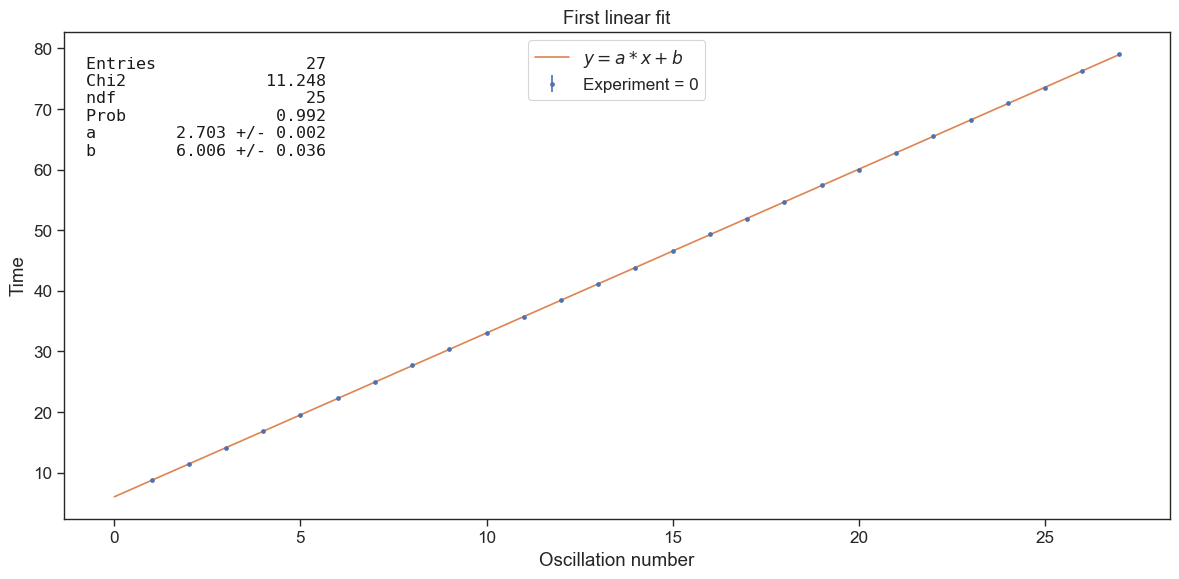

In [42]:
fig1, ax1 = plt.subplots(figsize = (12,6))

ax1.errorbar(x, y, yerr = sy, fmt = '.', label = f'Experiment = {experiment_number}')
ax1.set(title = "First linear fit",
        xlabel = 'Oscillation number',
        ylabel = 'Time')
ax1.plot(x_fit, y_fit_linear, '-', label = '$y = a*x+b$')
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.02, 0.95, text, ax1, fontsize=12)
ax1.legend(loc = 'upper center')
fig1.tight_layout();

if save_plots:
    fig1.savefig('first_linear_fit.pdf', dpi = 600) #remember to change title

## Histogramn residuals: Get estimation of error on T (and L)

In [18]:
#
Nbins = int(np.sqrt(Npoints)) # rule of thumb
xmin, xmax = -0.5, 0.5

In [19]:
tdist = tdiff - a # distance to fit parameter

### Fit to the data/ histogram (1D)
Using the fiting method binned likelihood-fit because the data is binned and low statistics.

I assume that the distances to the fit parameter is gaussian distributed.

In [20]:
def gauss_pdf(x, mu, sigma):
    '''normalised gaussian'''
    return 1/np.sqrt(2*np.pi)/sigma*np.exp(-0.5*(x-mu)**2/sigma**2)

def gauss_extended(x, N, mu, sigma):
    '''non-normalised gaussian'''
    return N*gauss_pdf(x, mu, sigma)

In [21]:
bllh = BinnedLH(gauss_extended,
               tdist,
               bins = Nbins,
               bound =(xmin, xmax),
               extended=True)

In [22]:
Minuit.print_level = 1
minuit_bllh = Minuit(bllh, mu = 0, sigma = 0.4, N = 10)
minuit_bllh.errordef = Minuit.LIKELIHOOD
minuit_bllh.migrad() #perform the actual fit

/Users/siljaxianpallisgaardsvendsen/Documents/KU_K/8_AppStat/AppStat2023/External_Functions/ExternalFunctionsNew.py:284: UserWarning: x is really small return 0
  warnings.warn('x is really small return 0')


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.02959                    │              Nfcn = 88               │
│ EDM = 4.2e-05 (Goal: 0.0001)     │            time = 0.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N     │    26     │     5     │            │            │         │         │       │
│ 1 │ mu    │  -0.008   │   0.022   │            │            │         │         │       │
│ 2 │ sigma │   0.090   │   0.016   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────┐
│       │         N        mu     sigma │
├───────┼───────────────────────────────┤
│     N │      25.8 -0.000346    0.0025 │
│    mu │ -0.000346  0.000465  8.59e-06 │
│ sigma │    0.0025  8.59e-06   0.00025 │
└───────┴───────────────────────────────┘

In [23]:
fit_N, fit_mu, fit_sigma = minuit_bllh.values[:]     # The fitted values of the parameters
for name in minuit_bllh.parameters:
    value, error = minuit_bllh.values[name], minuit_bllh.errors[name]
    print(f"  Fit value: {name} = {value:.5f} +/- {error:.5f}")
    
LLH_value = minuit_bllh.fval                         # The LogLikeliHood (LLH) value
print(f"  LLH value = {LLH_value:6.1f}")


  Fit value: N = 25.87162 +/- 5.07634
  Fit value: mu = -0.00819 +/- 0.02156
  Fit value: sigma = 0.09017 +/- 0.01582
  LLH value =    0.0


In [24]:
# used to plot fits
binwidth = (xmax-xmin)/ Nbins
x_fit = np.linspace(xmin, xmax, 1000)
y_fit = binwidth*gauss_extended(x_fit, fit_N, fit_mu, fit_sigma)

### Get statistics

In [25]:
# did not take the chi2 of binned likelihood fit because it is not costum.

### Plot binned data and fit

In [26]:
d = {'Entries':  Npoints,
     #'Mean':     x_all.mean(),
     #'Std':      x_all.std(ddof=1),
     # 'N':        [minuit.values['N'], minuit.errors['N']],
     'mu':       [minuit_bllh.values['mu'], minuit_bllh.errors['mu']],
     'sigma':    [minuit_bllh.values['sigma'], minuit_bllh.errors['sigma']],
     #'Chi2':     chi2_val,
     #'ndf':      N_DOF,
     #'Prob':     chi2_prob,
    }

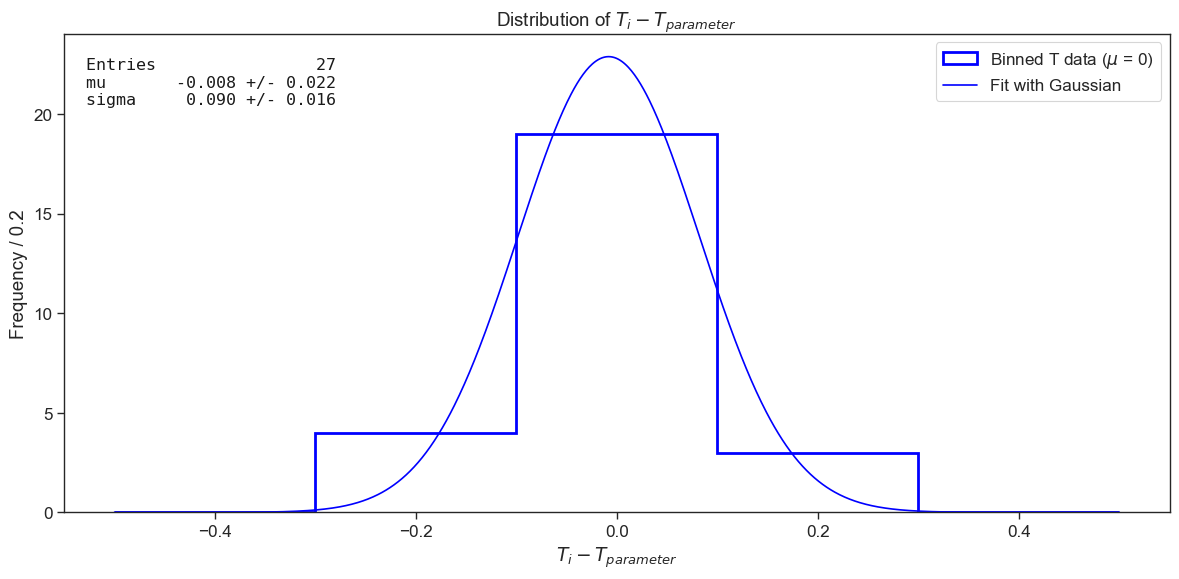

In [27]:
# plotting histogram and fit
fig2, ax2 = plt.subplots(figsize = (12,6))

hist = ax2.hist(tdist, bins=Nbins, range=(xmin, xmax),
                histtype='step', linewidth=2, color='blue',
                label='Binned T data ($\mu$ = 0)')

ax2.plot(x_fit, y_fit, '-', color ='blue', label = 'Fit with Gaussian')
ax2.set(xlabel = r'$T_i-T_{parameter}}$',
        ylabel = f'Frequency / {binwidth}',
        title = r'Distribution of $T_i-T_{parameter}$') # distribution of differences between Ti and the parameter value found in the first linear fit. 
ax2.legend(loc = 'best')
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.02, 0.95, text, ax2, fontsize=12)
fig2.tight_layout();

if save_plots:
    fig.save_plots('Histogram_period.pdf', dpi=600) #remember to change name

# Second Linear Fit (Get uncertainty on T)

In [28]:
x = pendulum[experiment_number][:,oscillation_number]
y = pendulum[experiment_number][:,time_point]
# update sy
# accuracy in each timing point obtained from fitting binned T data with a Gaussian
sy = minuit_bllh.values['sigma']*np.ones(Npoints)

if verbose:
    print(sy)

[0.09016509 0.09016509 0.09016509 0.09016509 0.09016509 0.09016509
 0.09016509 0.09016509 0.09016509 0.09016509 0.09016509 0.09016509
 0.09016509 0.09016509 0.09016509 0.09016509 0.09016509 0.09016509
 0.09016509 0.09016509 0.09016509 0.09016509 0.09016509 0.09016509
 0.09016509 0.09016509 0.09016509]


In [29]:
chi2 = Chi2Regression(linear_func, x, y, sy)
minuit_linear = Minuit(chi2, a=np.mean(tdiff), b=0 )
minuit_linear.errordef = Minuit.LEAST_SQUARES
minuit_linear.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 11.47                      │              Nfcn = 40               │
│ EDM = 3.05e-18 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │  2.7027   │  0.0022   │            │            │         │         │       │
│ 1 │ b    │   6.01    │   0.04    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────┐
│   │         a         b │
├───┼─────────────────────┤
│ a │  4.96e-06 -6.95e-05 │
│ b │ -6.95e-05   0.00127 │
└───┴─────────────────────┘

In [30]:
if (not minuit_linear.fmin.is_valid) :
    print("  WARNING: The ChiSquare fit DID NOT converge!!! ")
else :
    print("  The ChiSquare fit converged - congratulations")

  The ChiSquare fit converged - congratulations


In [31]:
# get fit parameters from minuit
a, b = minuit_linear.values[:]
print('Second linear fit')
for name in minuit_linear.parameters:
    print("Fit value: {0} = {1:.5f} +/- {2:.5f}".format(name,
                                                        minuit_linear.values[name],
                                                        minuit_linear.errors[name]))
    
# append to T_final and sigmaT_final
T_final.append(minuit_linear.values[0])      #slope
sigmaT_final.append(minuit_linear.errors[0]) # error on slope

Second linear fit
Fit value: a = 2.70272 +/- 0.00223
Fit value: b = 6.00623 +/- 0.03569


In [32]:
# plot fit
x_fit = np.linspace(0, 25, 1000)
y_fit_linear = linear_func(x_fit, a, b)

In [33]:
NDOF = Npoints - len(minuit_linear.values[:])
chi2_val = minuit_linear.fval
chi2_prob = stats.chi2.sf(chi2_val, NDOF)
print('p-value:', chi2_prob)

p-value: 0.990368013826677


In [34]:
d = {'Entries':  Npoints,
     'Chi2':     chi2_val,
     'ndf':      NDOF,
     'Prob':     chi2_prob,
    }


for name in minuit_linear.parameters:
    d[name] = [minuit_linear.values[name], minuit_linear.errors[name]]

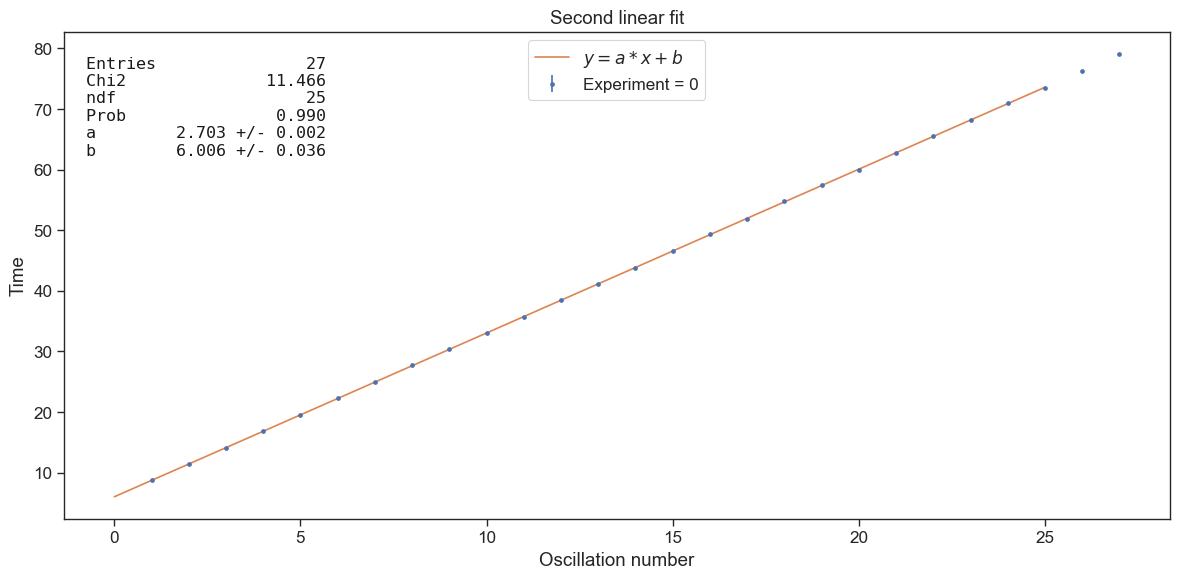

In [35]:
fig3, ax3 = plt.subplots(figsize = (12,6))

ax3.errorbar(x, y, yerr = sy, fmt = '.', label = f'Experiment = {experiment_number}')
ax3.set(title = "Second linear fit",
        xlabel = 'Oscillation number',
        ylabel = 'Time')
ax3.plot(x_fit, y_fit_linear, '-', label = '$y = a*x+b$')
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.02, 0.95, text, ax3, fontsize=12)
ax3.legend(loc = 'upper center')
fig3.tight_layout();

if save_plots:
    fig1.savefig('second_linear_fit.pdf', dpi = 600) #remember to change title

The uncertainty on the slope of the fit is the uncertainty on the period.

From a previous notebook it mentions that one expect a p-value around 0.5 by construction. Why do I not get that?

From this plot, there is not much fluctuations around the fit function. It makes sense that I have a p-value around 0.9.

# Period T and its error
Period on T is then a weighted mean of `T_final` and the error should be a weighted error using `sigmaT_final`.

In [36]:
print ('T measurements from second linear fit and errors on T are obtained from histogram plot.',
       '\nT: ', T_final, '\nUncertainty on T',sigmaT_final)

def weighted_mean(measurement, error):
    '''Barlow eq. 4.6'''
    for xi,sigi in zip(measurement, error):
        mean = 0
        mean += (xi/sigi**2)/(1/sigi**2)
    return mean

def weighted_error(error):
    '''Barlow eq. 4.7'''
    for sigi in error:
        var = 0
        var += 1/(1/sigi**2)
    return np.sqrt(var)


#################
#    RESULTS    #
#################

Tmean = weighted_mean(T_final, sigmaT_final)
sigTmean = weighted_error(sigmaT_final)

print('\n\n',f'Results: T_mean = {Tmean} +/- {sigTmean}')

T measurements from second linear fit and errors on T are obtained from histogram plot. 
T:  [2.70272118437084] 
Uncertainty on T [0.0022278274205688193]


 Results: T_mean = 2.7027211843708394 +/- 0.0022278274205688193


# Length of pendulum

In [37]:
L_data = np.array([53,56,45]) # measure the lenth individually!
L_est = np.mean(L_data)
sigmaL_est = np.sqrt(np.mean((L_data-L_est)**2)) 

print('L = {0:.1f} +/- {1:.1f} cm'.format(L_est, sigmaL_est))

L = 51.3 +/- 4.6 cm


# Calculate g

## Calculate error on g using error propagation formula.

In [38]:
##############
# Parameters #
##############

L, T, sigma_L, sigma_T,rho_TL = L_est, Tmean, sigmaL_est, sigTmean, 0
rhoTL = 0 # period and length is uncorrelated
sigT = sigTmean
muT = Tmean
sigL = sigmaL_est
muL = L_est

In [39]:
g1 = muL * (2*np.pi/muT)**2
print(g1)

277.4321013669616


In [40]:
# Import SymPy: 
from sympy import * 

# Define variables:
L,T, g = symbols("L, T, g")
dL,dT, dg = symbols("sigma_L, sigma_T, sigma_g")


# Define relation, and print:
g = L * (2*pi/T)**2

lprint(latex(Eq(symbols('g'),g)))

# Calculate uncertainty and print:
dg = sqrt((g.diff(L) * dL)**2 + (g.diff(T) * dT)**2 + 2* g.diff(L)*g.diff(T)*rhoTL*sigT*sigL)


lprint(latex(Eq(symbols('sigma_g'), dg)))

# Turn expression into numerical functions 
fg = lambdify((T,L),g)
fdg = lambdify((T,dT,L,dL),dg)

# Define values and their errors
vT, vdT = muT, sigT
vL, vdL = muL, sigL

# Numerically evaluate expressions and print 
vg = fg(vL,vT)
vdg = fdg(vL,vdL,vT,vdT)

lprint(fr'g = ({vg:.1f} \pm {vdg:.1f})\,\mathrm{{m}}')

# NOTE: Do the above analytical calculation before you continue below! Possibly use SymPy for the differentiations.

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [41]:
# SOMTHING IS WRONG WITH THE SYMPY CALCULATION!!!